In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import src.helpers as hlp
from nltk.tokenize import TweetTokenizer
tweet_tokenizer = TweetTokenizer()
from gensim.models import word2vec
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import torch
import torch.nn as nn

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\danie\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\danie\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\danie\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
VECT_SIZE = 100

In [3]:
t_pos = pd.read_table("data/train_pos.txt", header=None, names=['tweet'], dtype=str,on_bad_lines='skip')
t_pos['label'] = 1
t_neg = pd.read_table("data/train_neg.txt", header=None, names=['tweet'], dtype=str,on_bad_lines='skip')
t_neg['label'] = 0
df = pd.concat((t_pos,t_neg))

In [4]:
df['tweet'] = df['tweet'].apply(lambda x: hlp.remove_stopwords(x))
df['tweet'] = df['tweet'].apply(lambda x: hlp.remove_punct(x))
df['tweet'] = df['tweet'].apply(lambda x: hlp.add_space(x))
df['tweet'] = df['tweet'].apply(lambda x: hlp.remove_white_space(x))
df['tweet'] = df['tweet'].apply(lambda x: hlp.remove_words_digits(x))
df['tweet'] = df['tweet'].apply(lambda x: hlp.to_lower(x))
df['tweet'] = df['tweet'].apply(lambda x: hlp.remove_specific_words(x))
df['tweet'] = df['tweet'].apply(lambda x: hlp.remove_repeating_char(x))
df['tweet'] = df['tweet'].apply(lambda x: hlp.remove_single_char(x))
df['tweet'] = df['tweet'].apply(lambda x: hlp.lemmatize(x))
df['tweet'] = df['tweet'].apply(lambda s: tweet_tokenizer.tokenize(s))

In [5]:
X_train, X_test, y_train, y_test = train_test_split (df['tweet'], df['label'] , test_size=0.2)

In [6]:
w2c_model = word2vec.Word2Vec(sentences=X_train, vector_size=VECT_SIZE, window=5, min_count=1, workers=4)

In [7]:
def vectorize(model_train, dataset):
    words = set(model_train.wv.index_to_key)
    X_train_vect = np.array([np.array([model_train.wv[i] for i in ls if i in words])for ls in dataset])
    X_train_vect_avg = []
    for v in X_train_vect:
        if v.size:
            X_train_vect_avg.append(np.append(v.mean(axis=0),1))
        else:
            X_train_vect_avg.append(np.zeros(VECT_SIZE+1, dtype=float))
    return X_train_vect_avg


In [8]:
w2c_X_train_vect = vectorize(w2c_model, X_train)
w2c_X_test_vect = vectorize(w2c_model, X_test)

C:\Users\danie\AppData\Local\Temp\ipykernel_22364\3706557185.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_train_vect = np.array([np.array([model_train.wv[i] for i in ls if i in words])for ls in dataset])


In [15]:
LSVC = LinearSVC(verbose=1, max_iter=2000)
LSVC.fit(w2c_X_train_vect, y_train)

[LibLinear]

c:\Users\danie\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(max_iter=2000, verbose=1)

In [16]:
y_pred = LSVC.predict(w2c_X_test_vect)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.72      0.73     19773
           1       0.72      0.74      0.73     19621

    accuracy                           0.73     39394
   macro avg       0.73      0.73      0.73     39394
weighted avg       0.73      0.73      0.73     39394



In [17]:
class TrainDataset(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
    
    def __getitem__(self, index):
        return self.y_data[index], self.X_data[index] 

    def __len__(self):
        return len(self.X_data)

In [18]:
class TestDataset(Dataset):
    def __init__(self, X_data):
        self.X_data = X_data
    
    def __getitem__(self, index):
        return self.X_data[index]

    def __len__(self):
        return len(self.X_data)

In [19]:
train_data = TrainDataset(torch.FloatTensor(w2c_X_train_vect), torch.LongTensor(y_train.values))
test_data = TrainDataset(torch.FloatTensor(w2c_X_test_vect), torch.LongTensor(y_test.values))

C:\Users\danie\AppData\Local\Temp\ipykernel_22364\1166895078.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:233.)
  train_data = TrainDataset(torch.FloatTensor(w2c_X_train_vect), torch.LongTensor(y_train.values))


In [20]:
train_loader = DataLoader(dataset=train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1)

In [21]:
def train_loop(dataloader, model, loss_fn, optimizer):
        train_loss, correct = 0,0
        for y_batch, X_batch in tqdm(dataloader):

                pred = model(X_batch)
                loss = loss_fn(pred, y_batch)

                train_loss += loss.item()
                correct += (pred.argmax(1) == y_batch).type(torch.float).sum().item()

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
        train_loss /= len(dataloader)
        correct /= len(dataloader.dataset)
        print(f"Train Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {train_loss:>8f} \n")
        return train_loss, correct

In [22]:
def test_loop(dataloader, model, loss_fn):
    test_loss, correct = 0,0
    with torch.no_grad():
        for y, X in dataloader:

            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= len(dataloader)
    correct /= len(dataloader.dataset)
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss, correct



In [23]:
def train(model, train_loader, valid_loader, num_epochs, learning_rate):
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    losses, train_accs, test_accs = [], [], []
    for epoch in range(num_epochs):
        print(f"Epoch : {epoch+1}\n")
        train_loss, train_acc = train_loop(train_loader, model, loss_fn, optimizer)
        test_loss, test_acc = test_loop(test_loader, model, loss_fn)
        losses.append(float(train_loss))
        train_accs.append(train_acc)
        test_accs.append(test_acc)
    
    plt.title("Training")
    plt.plot(losses, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(train_accs, label="Train")
    plt.plot(test_accs, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()



In [24]:
model = nn.Sequential(nn.Linear(VECT_SIZE+1, 100),
                        nn.ReLU(),
                        nn.Dropout(p=0.5),
                        nn.Linear(100, 2),
                        nn.Softmax(1))

Epoch : 1



100%|██████████| 2463/2463 [00:04<00:00, 511.65it/s]


Train Error: 
 Accuracy: 71.4%, Avg loss: 0.573167 

Test Error: 
 Accuracy: 72.2%, Avg loss: 0.565800 

Epoch : 2



100%|██████████| 2463/2463 [00:03<00:00, 660.65it/s]


Train Error: 
 Accuracy: 72.2%, Avg loss: 0.566962 

Test Error: 
 Accuracy: 72.8%, Avg loss: 0.562626 

Epoch : 3



100%|██████████| 2463/2463 [00:05<00:00, 483.46it/s]


Train Error: 
 Accuracy: 72.6%, Avg loss: 0.564009 

Test Error: 
 Accuracy: 72.9%, Avg loss: 0.561504 

Epoch : 4



100%|██████████| 2463/2463 [00:05<00:00, 428.50it/s]


Train Error: 
 Accuracy: 72.9%, Avg loss: 0.562714 

Test Error: 
 Accuracy: 72.9%, Avg loss: 0.564500 

Epoch : 5



100%|██████████| 2463/2463 [00:05<00:00, 436.89it/s]


Train Error: 
 Accuracy: 72.9%, Avg loss: 0.561426 

Test Error: 
 Accuracy: 73.0%, Avg loss: 0.558866 

Epoch : 6



100%|██████████| 2463/2463 [00:05<00:00, 481.20it/s]


Train Error: 
 Accuracy: 73.0%, Avg loss: 0.560754 

Test Error: 
 Accuracy: 73.4%, Avg loss: 0.558794 

Epoch : 7



100%|██████████| 2463/2463 [00:05<00:00, 486.24it/s]


Train Error: 
 Accuracy: 73.1%, Avg loss: 0.560020 

Test Error: 
 Accuracy: 72.9%, Avg loss: 0.564783 

Epoch : 8



100%|██████████| 2463/2463 [00:05<00:00, 446.47it/s]


Train Error: 
 Accuracy: 73.1%, Avg loss: 0.560032 

Test Error: 
 Accuracy: 73.2%, Avg loss: 0.557041 

Epoch : 9



100%|██████████| 2463/2463 [00:05<00:00, 431.75it/s]


Train Error: 
 Accuracy: 73.2%, Avg loss: 0.559366 

Test Error: 
 Accuracy: 72.9%, Avg loss: 0.560728 

Epoch : 10



100%|██████████| 2463/2463 [00:05<00:00, 433.78it/s]


Train Error: 
 Accuracy: 73.3%, Avg loss: 0.558833 

Test Error: 
 Accuracy: 72.7%, Avg loss: 0.560230 



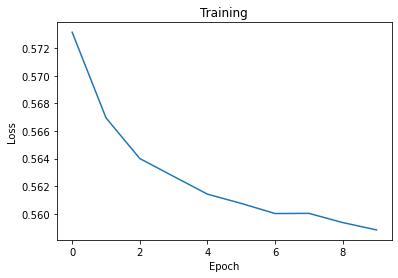

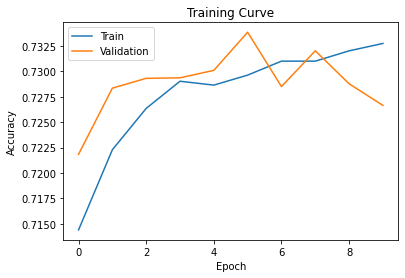

In [25]:
train(model, train_loader, test_loader, num_epochs=10, learning_rate=1e-2)